### Multiple-Layer Perceptron
#### Youn-Long Lin, NTHU-CS
#### 2019 02 25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=2)

In [2]:
class MLP():
    def __init__(self, listOfLayer=[2, 3, 2], activationFunction="ReLU"):
        self.numLayers = len(listOfLayer)
        self.layers = [{} for i in range(self.numLayers)]
        self.activationFunction = activationFunction
        
        for i in range(1, self.numLayers):
            self.layers[i]["W"] = np.random.randn(listOfLayer[i], listOfLayer[i-1])
            self.layers[i]["b"] = np.random.randn(listOfLayer[i], 1)
        self.lossList = []
        return
            
    def forward(self, x, bs):
        self.layers[0]["a"] = np.copy(x)
        for i in range(1, self.numLayers):
            self.layers[i]["z"] = self.layers[i]["W"].dot(self.layers[i-1]["a"]) + self.layers[i]["b"]
            actType = "sigmoid" if i == self.numLayers - 1 else self.activationFunction
            self.layers[i]["a"] = self.activation(self.layers[i]["z"], actType)
        self.p = self.softmax(self.layers[-1]["a"])
        self.yHat = np.zeros(self.p.shape, dtype=int)
        for j, i in enumerate(self.p.argmax(axis=0)):
            self.yHat[i, j] = 1
        return
    
    def activation(self, z, actType="sigmoid"):
        if actType == "sigmoid":
            a = 1.0 / (1.0 + np.exp(-z))
        elif actType == "ReLU":
            a = np.where(z < 0.0, 0.0, z)
        else:
            pass   
        return a
     
    def inverseActivation(self, a, actType="sigmoid"):
        if actType == "sigmoid":
            dzda = a * (1.0 - a)
        elif actType == "ReLU":
            dzda = np.where(a > 0, 1.0, a)
        else:
            pass
        return dzda
    
    def softmax(self, a):
        expa = np.exp(a)
        return (expa / np.sum(expa, axis = 0))
    
    def loss(self, y):
        # return np.mean(- np.log(self.p) * y - np.log(1.0 - self.p) * (1.0 - y))
        return np.mean(- np.log(self.p) * y)
        
    def backprop(self, y, bs):
        # self.dJdp = - y / self.p + (1.0 - y) / (1.0 - self.p)
        self.dJdp = - y / self.p # To count only the correct answer
        
        dpda = np.zeros((self.p.shape[0], self.p.shape[0], bs)) # a and p are of same dimension
        for b in range(bs):
            for i in range(dpda.shape[0]):
                for j in range(dpda.shape[1]):
                    dpda[i, j, b] = (self.p[i, b] - self.p[i, b] ** 2) if i == j else - self.p[i, b] * self.p[j, b]
        
        self.layers[-1]["dJda"] = np.zeros(self.layers[-1]["a"].shape)
        for b in range(bs):
            self.layers[-1]["dJda"][:, b] = dpda[:, :, b].dot(self.dJdp[:, b])
          
        for i in range(self.numLayers - 1, 0, -1):
            actType = "sigmoid" if i == self.numLayers - 1 else self.activationFunction
            self.layers[i]["dJdz"] = self.inverseActivation(self.layers[i]["a"], actType) * self.layers[i]["dJda"]
            self.layers[i]["dJdb"] = np.mean(self.layers[i]["dJdz"], axis = 1).reshape(self.layers[i]["b"].shape)
            self.layers[i]["dJdW"] = self.layers[i]["dJdz"].dot(self.layers[i-1]["a"].T) / bs
            self.layers[i-1]["dJda"] = self.layers[i]["W"].T.dot(self.layers[i]["dJdz"])
        return
            
    def update(self, lr = 0.01):
        for i in range(1, self.numLayers):
            self.layers[i]["W"] -= lr * self.layers[i]["dJdW"]
            self.layers[i]["b"] -= lr * self.layers[i]["dJdb"]
        return
    
    def shuffle(self, a, b):
        shuffled_a = np.copy(a)
        shuffled_b = np.copy(b)
        permutation = np.random.permutation(a.shape[1])
        for oldindex, newindex in enumerate(permutation):
            shuffled_a[:, oldindex] = a[:, newindex]
            shuffled_b[:, oldindex] = b[:, newindex]
        return shuffled_a, shuffled_b
        
    def train(self, trainX, trainY, numEpoch=1, lr=0.01, bs=2):  
        for e in range(numEpoch):
            shuffled_trainX, shuffled_trainY = self.shuffle(trainX, trainY)
            for i in range(trainX.shape[1] // bs):
                x = shuffled_trainX[:, i*bs : (i+1)*bs]
                y = shuffled_trainY[:, i*bs : (i+1)*bs]
                self.forward(x, bs)
                self.lossList.append(self.loss(y))
                self.backprop(y, bs)
                self.update(lr)
        self.finalX = shuffled_trainX
        self.finalY = shuffled_trainY
        return      

### Train a toy neural net

In [3]:
nn = MLP([2, 10, 10, 2], activationFunction = "sigmoid")

In [4]:
trainX = np.array([[1, 4, 2, 1, 2, 4],
                  [1, 2, 2, 4, 3, 4]])
trainY = np.array([[0, 0, 0, 1, 1, 0],
                  [1, 1, 1, 0, 0, 1]])

In [5]:
nn.train(trainX, trainY, numEpoch=10000, lr=0.1, bs = 6)

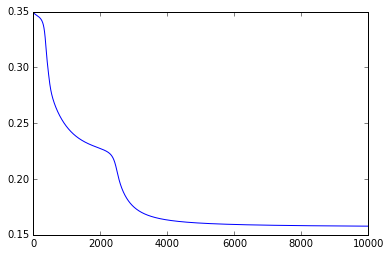

In [6]:
plt.plot(nn.lossList[:])

In [7]:
print ("yHat is\n", nn.yHat)
print ("y is \n", trainY)

yHat is
 [[0 0 0 1 1 0]
 [1 1 1 0 0 1]]
y is 
 [[0 0 0 1 1 0]
 [1 1 1 0 0 1]]


In [8]:
nn.layers[-1]["a"]

array([[  4.34e-03,   5.03e-03,   4.01e-03,   9.87e-01,   9.98e-01,
          4.51e-04],
       [  9.97e-01,   9.96e-01,   9.97e-01,   8.38e-03,   1.90e-03,
          9.99e-01]])

### Train a set of 10 MNIST digits

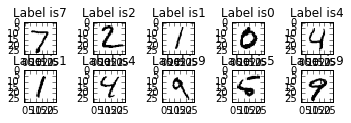

In [9]:
f = open("mnist_test_10.csv", "r")
a = f.readlines()
f.close()

x = []
y = []
count = 1
for line in a:
    linepixels = [int(pixel) for pixel in line.split(",")]
    x.append(linepixels[1:])
    y.append(linepixels[0])
    imarray = np.asfarray(linepixels[1:]).reshape(28,28)
    plt.subplot(5, 5, count)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is" + str(linepixels[0]))
    count += 1
    plt.imshow(imarray, cmap="Greys", interpolation="None")
    
test_x_10 = np.array(x).T / 256.0
test_y_10 = np.zeros((10, len(y)), dtype=int)
for i in range(len(y)):
    test_y_10[y[i], i] = 1

In [10]:
test_y_10

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])

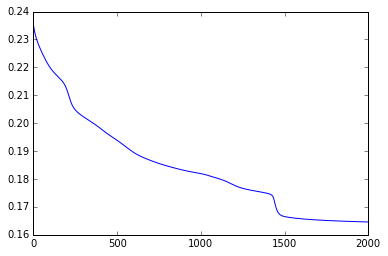

In [11]:
nnMNIST = MLP([784, 50, 10], activationFunction = "sigmoid")
nnMNIST.train(test_x_10, test_y_10, numEpoch=2000, lr=0.1, bs = 10)
plt.plot(nnMNIST.lossList[:])

In [15]:
nnMNIST.forward(test_x_10, 10)
predicted = nnMNIST.yHat.argmax(axis=0)
answer = test_y_10.argmax(axis=0)
accuracy = 1.0 - float(len(np.nonzero(predicted - answer)[0])) / len(answer)
print ("Training Accuracy=", accuracy)

Training Accuracy= 0.8


In [16]:
nnMNIST.yHat.argmax(axis=0)

array([9, 2, 1, 0, 4, 1, 4, 9, 0, 9])

In [17]:
nnMNIST.p

array([[ 0.1 ,  0.09,  0.09,  0.23,  0.08,  0.09,  0.09,  0.09,  0.11,
         0.09],
       [ 0.1 ,  0.09,  0.23,  0.09,  0.08,  0.23,  0.09,  0.08,  0.1 ,
         0.09],
       [ 0.1 ,  0.23,  0.09,  0.1 ,  0.08,  0.09,  0.09,  0.09,  0.1 ,
         0.09],
       [ 0.1 ,  0.08,  0.09,  0.08,  0.09,  0.09,  0.08,  0.09,  0.1 ,
         0.08],
       [ 0.1 ,  0.09,  0.09,  0.09,  0.23,  0.09,  0.23,  0.09,  0.1 ,
         0.09],
       [ 0.1 ,  0.08,  0.09,  0.08,  0.08,  0.09,  0.09,  0.09,  0.1 ,
         0.08],
       [ 0.1 ,  0.08,  0.09,  0.09,  0.09,  0.09,  0.09,  0.09,  0.1 ,
         0.09],
       [ 0.1 ,  0.08,  0.09,  0.09,  0.08,  0.09,  0.08,  0.08,  0.1 ,
         0.08],
       [ 0.1 ,  0.08,  0.09,  0.08,  0.09,  0.09,  0.09,  0.09,  0.1 ,
         0.09],
       [ 0.1 ,  0.08,  0.09,  0.08,  0.09,  0.09,  0.09,  0.23,  0.1 ,
         0.23]])

### Train a subset of 100 MNIST data

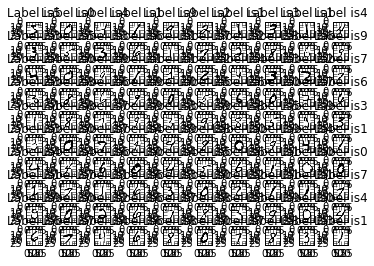

In [19]:
f = open("mnist/mnist_train_100.csv", "r")
a = f.readlines()
f.close()

x = []
y = []
count = 1
for line in a:
    linepixels = [int(pixel) for pixel in line.split(",")]
    x.append(linepixels[1:])
    y.append(linepixels[0])
    imarray = np.asfarray(linepixels[1:]).reshape(28,28)
    plt.subplot(10, 10, count)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is" + str(linepixels[0]))
    count += 1
    plt.imshow(imarray, cmap="Greys", interpolation="None")
    
train_x_100 = np.array(x).T / 256.0
train_y_100 = np.zeros((10, len(y)), dtype=int)
for i in range(len(y)):
    train_y_100[y[i], i] = 1

In [20]:
nnMNIST100 = MLP([784, 50, 10], activationFunction = "sigmoid")
nnMNIST100.train(train_x_100, train_y_100, numEpoch=10000, lr=0.1, bs = 100)

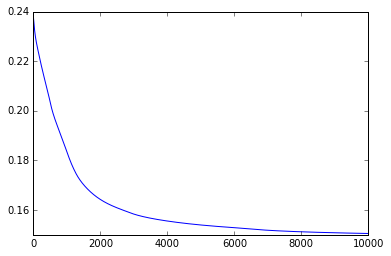

In [21]:
plt.plot(nnMNIST100.lossList[:])

In [22]:
nnMNIST100.finalY.argmax(axis=0)

array([3, 7, 2, 0, 3, 3, 0, 2, 9, 2, 1, 4, 6, 8, 3, 6, 1, 1, 4, 8, 8, 6, 7,
       4, 3, 2, 7, 5, 3, 9, 1, 9, 6, 7, 7, 5, 0, 0, 5, 4, 3, 0, 3, 4, 6, 7,
       4, 9, 3, 1, 4, 6, 1, 8, 0, 1, 9, 9, 0, 5, 6, 4, 0, 3, 0, 8, 4, 9, 6,
       6, 0, 2, 6, 1, 5, 9, 0, 0, 4, 1, 1, 1, 6, 1, 7, 7, 7, 9, 8, 8, 1, 1,
       2, 7, 0, 3, 9, 8, 9, 4])

In [23]:
nnMNIST100.yHat.argmax(axis=0)

array([3, 7, 2, 0, 3, 3, 0, 2, 9, 2, 1, 4, 6, 8, 3, 6, 1, 1, 1, 8, 8, 6, 7,
       4, 3, 1, 7, 5, 3, 9, 1, 9, 6, 7, 7, 3, 0, 0, 0, 4, 3, 0, 3, 4, 6, 7,
       4, 9, 3, 1, 7, 6, 1, 8, 0, 1, 9, 9, 0, 5, 6, 4, 0, 3, 0, 8, 4, 9, 6,
       6, 0, 2, 6, 1, 5, 9, 0, 0, 4, 1, 1, 1, 6, 1, 7, 7, 7, 9, 8, 8, 1, 1,
       2, 7, 0, 3, 9, 8, 9, 4])

In [24]:
nnMNIST100.forward(train_x_100, 100)
predicted = nnMNIST100.yHat.argmax(axis=0)
answer = train_y_100.argmax(axis=0)
accuracy = 1.0 - float(len(np.nonzero(predicted - answer)[0])) / len(answer)
print ("Training Accuracy=", accuracy)

Training Accuracy= 0.95


In [25]:
print("dJdp\n", np.histogram(nnMNIST100.dJdp))
print("dJda last\n", np.histogram(nnMNIST100.layers[-1]["dJda"]))
print("dJdW last\n", np.histogram(nnMNIST100.layers[-1]["dJdW"]))
print("dJda first\n", np.histogram(nnMNIST100.layers[1]["dJda"]))
print("dJdW first\n", np.histogram(nnMNIST100.layers[1]["dJdW"]))

dJdp
 (array([  3,   0,   0,   0,   1,  96,   0,   0,   0, 900]), array([-10.22,  -9.2 ,  -8.17,  -7.15,  -6.13,  -5.11,  -4.09,  -3.07,
        -2.04,  -1.02,   0.  ]))
dJda last
 (array([  5,  95,   0,   0,   0,   0,   0,   0, 846,  54]), array([-0.9 , -0.79, -0.68, -0.57, -0.46, -0.35, -0.24, -0.13, -0.02,
        0.09,  0.2 ]))
dJdW last
 (array([ 16,  26,  68,  98, 155,  82,  38,  11,   3,   3]), array([ -3.96e-04,  -2.92e-04,  -1.88e-04,  -8.40e-05,   2.01e-05,
         1.24e-04,   2.28e-04,   3.32e-04,   4.36e-04,   5.40e-04,
         6.44e-04]))
dJda first
 (array([   4,    5,   22,  162, 3356, 1346,   75,   21,    5,    4]), array([-0.13, -0.11, -0.08, -0.05, -0.02,  0.  ,  0.03,  0.06,  0.09,
        0.11,  0.14]))
dJdW first
 (array([    6,   116,   923,  6804, 30017,  1123,   142,    31,    16,    22]), array([ -1.43e-04,  -1.08e-04,  -7.35e-05,  -3.86e-05,  -3.71e-06,
         3.12e-05,   6.60e-05,   1.01e-04,   1.36e-04,   1.71e-04,
         2.06e-04]))


In [26]:
np.histogram(nnMNIST100.layers[1]['z'])

(array([   7,   36,  165,  615, 1433, 1479,  914,  292,   46,   13]),
 array([-40.22, -32.55, -24.88, -17.21,  -9.53,  -1.86,   5.81,  13.49,
         21.16,  28.83,  36.5 ]))

In [27]:
np.histogram(nnMNIST100.layers[-1]['z'])

(array([  9,  53, 147, 285, 317,  89,   1,   6,  82,  11]),
 array([-15.73, -13.3 , -10.87,  -8.44,  -6.01,  -3.58,  -1.15,   1.28,
          3.71,   6.14,   8.57]))

In [28]:
nnMNIST100.p[:, -10:]

array([[ 0.09,  0.09,  0.08,  0.09,  0.09,  0.23,  0.09,  0.09,  0.08,
         0.09],
       [ 0.09,  0.09,  0.08,  0.08,  0.09,  0.08,  0.09,  0.09,  0.09,
         0.23],
       [ 0.09,  0.09,  0.09,  0.09,  0.09,  0.08,  0.09,  0.09,  0.09,
         0.09],
       [ 0.09,  0.09,  0.08,  0.09,  0.09,  0.08,  0.09,  0.08,  0.23,
         0.09],
       [ 0.09,  0.09,  0.23,  0.09,  0.09,  0.09,  0.09,  0.09,  0.09,
         0.09],
       [ 0.09,  0.09,  0.08,  0.09,  0.09,  0.08,  0.09,  0.09,  0.09,
         0.09],
       [ 0.23,  0.09,  0.08,  0.23,  0.09,  0.09,  0.09,  0.09,  0.09,
         0.09],
       [ 0.09,  0.23,  0.08,  0.08,  0.09,  0.09,  0.23,  0.09,  0.08,
         0.09],
       [ 0.09,  0.09,  0.08,  0.09,  0.23,  0.08,  0.09,  0.23,  0.08,
         0.09],
       [ 0.09,  0.09,  0.09,  0.09,  0.09,  0.09,  0.09,  0.09,  0.09,
         0.09]])

### Train the full MNIST set of 60000 data points

In [29]:
def csv2xy(fileName):
    f = open(fileName, "r")
    a = f.readlines()
    f.close()

    x = []
    y = []

    for line in a:
        linepixels = [int(pixel) for pixel in line.split(",")]
        x.append(linepixels[1:])
        y.append(linepixels[0])
    
    
    out_x = np.array(x).T / 256.0
    out_y = np.zeros((10, len(y)), dtype=int)
    for i in range(len(y)):
        out_y[y[i], i] = 1
        
    return out_x, out_y
    
train_x_60000, train_y_60000 = csv2xy("mnist_train_60000.csv")
test_x_10000, test_y_10000 = csv2xy("mnist_test_10000.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'mnist_train_60000.csv'

In [30]:
nnMNIST60000 = MLP([784, 50, 10], activationFunction='sigmoid')

In [31]:
nnMNIST60000.train(train_x_60000, train_y_60000, numEpoch=100, lr=0.1, bs = 100)
plt.plot(nnMNIST60000.lossList)

NameError: name 'train_x_60000' is not defined

In [32]:
nnMNIST60000.forward(train_x_60000, 60000)
predicted = nnMNIST60000.yHat.argmax(axis=0)
answer = train_y_60000.argmax(axis=0)
accuracy = 1.0 - float(len(np.nonzero(predicted - answer)[0])) / len(answer)
print ("Training Accuracy=", accuracy)

NameError: name 'train_x_60000' is not defined

In [33]:
nnMNIST60000.forward(test_x_10000, 10000)
predicted = nnMNIST60000.yHat.argmax(axis=0)
answer = test_y_10000.argmax(axis=0)
accuracy = 1.0 - float(len(np.nonzero(predicted - answer)[0])) / len(answer)
print ("Testing Accuracy=", accuracy)

NameError: name 'test_x_10000' is not defined

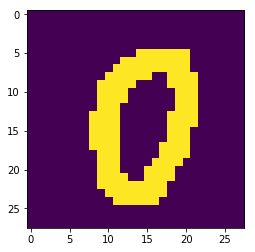

In [38]:
img = np.asfarray(train_x_60000[:, 1000]).reshape(28,28)
plt.imshow(img)